
Start Time : 2023-09-18 17:26:59.563289


/Users/chrisfinlay/mambaforge/envs/pyro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model : fixed_orbit_rfi_compressed_fft_standard

Mean RFI Amp. : 109 Jy
Flag Rate :     92.21 %

Number of Antennas   :    8
Number of Time Steps :  450

Number of parameters per antenna/baseline
Gains :    2
RFI   :  121
AST   :  450

Number of parameters : 27166
Number of data points: 25200

End Time   : 2023-09-18 17:27:03.717593
Total Time : 0:00:04.154304

Reduced Chi^2 @ true: 0.9937159878207913


Reduced Chi^2 @ init: 87.73427845899025


End Time  : 2023-09-18 17:27:14.744501
Plot Time : 0:00:11.026908

End Time  : 2023-09-18 17:27:21.739580
Plot Time : 0:00:06.995079

End Time  : 2023-09-18 17:27:21.739599
Plot Time : 0:00:00.000019


100%|██████████| 2000/2000 [00:14<00:00, 139.46it/s, init loss: 23810716.1784, avg. loss [1901-2000]: 271903.9261]



Reduced Chi^2 : 0.9262987464907513



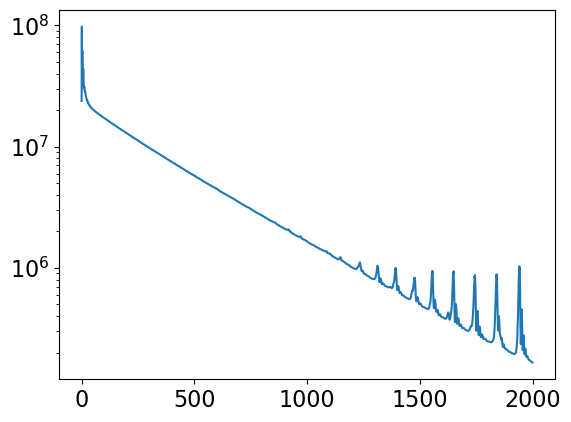


End Time  : 2023-09-18 17:27:44.681399
Plot Time : 0:00:22.941819

End Time  : 2023-09-18 17:27:44.681415
Infer Time : 0:00:00.000016


In [1]:
run tab_II_numpyro_gp_fft_standard.py

In [81]:
@jit
def flatten_obs(vis_obs):
    return jnp.concatenate([vis_obs.real.flatten(), vis_obs.imag.flatten()])

@jit
def f_model(params, args):
    return fixed_orbit_rfi_compressed_fft_standard_model(params, args)[0]

@partial(jit, static_argnums=(0,))
def f_model_flat(model, params, args):
    vis_obs = model(params, args)
    vis_obs_flat = flatten_obs(vis_obs)
    return vis_obs_flat

In [82]:
f_model(true_params_base, args).shape

(28, 450)

In [84]:
f_model_flat(f_model, true_params_base, args).shape

(25200,)

In [5]:
from jax import jvp, vjp, jit, vmap, random
from jax.flatten_util import ravel_pytree as flatten
from jax.scipy.sparse.linalg import cg
from functools import partial

In [6]:
@partial(jit, static_argnums=(0,))
def vjp_(f, x, y):
    _, vjp_fun = vjp(f, x)
    return vjp_fun(y)[0]

In [7]:
tree_map(jnp.shape, vjp_(lambda x: f_model_flat(x, args), true_params_base, flatten_obs(vis_obs)))

{'ast_k_i_base': (28, 450),
 'ast_k_r_base': (28, 450),
 'g_amp_induce_base': (8, 2),
 'g_phase_induce_base': (7, 2),
 'rfi_i_induce_base': (8, 121),
 'rfi_r_induce_base': (8, 121)}

In [8]:
@partial(jit, static_argnums=(0,))
def fvp(f, x, v):
    pushforward = jvp(f, (x,), (v,))[1]
    _, vjp_fun = vjp(f, x)
    return vjp_fun(pushforward)[0]

In [9]:
@partial(jit, static_argnums=(0,))
def post_fvp(f, x, v):
    return tree_map(jnp.add, fvp(f, x, v), v)

In [10]:
tree_map(jnp.shape, post_fvp(lambda x: f_model_flat(x, args), true_params_base, true_params_base))

{'ast_k_i_base': (28, 450),
 'ast_k_r_base': (28, 450),
 'g_amp_induce_base': (8, 2),
 'g_phase_induce_base': (7, 2),
 'rfi_i_induce_base': (8, 121),
 'rfi_r_induce_base': (8, 121)}

In [11]:
@partial(jit, static_argnums=(0,))
def inv_post_fvp(f, x, v, max_iter):
    return cg(lambda v: post_fvp(f, x, v), v, maxiter=max_iter)[0]

In [12]:
tree_map(jnp.shape, inv_post_fvp(lambda x: f_model_flat(x, args), true_params_base, true_params_base, max_iter=1_000))

{'ast_k_i_base': (28, 450),
 'ast_k_r_base': (28, 450),
 'g_amp_induce_base': (8, 2),
 'g_phase_induce_base': (7, 2),
 'rfi_i_induce_base': (8, 121),
 'rfi_r_induce_base': (8, 121)}

In [13]:
flat_true, unflatten = flatten(true_params_base)
tree_map(jnp.shape, vmap(lambda x: unflatten(x))(random.normal(random.PRNGKey(1), (10,flat_true.size))))

{'ast_k_i_base': (10, 28, 450),
 'ast_k_r_base': (10, 28, 450),
 'g_amp_induce_base': (10, 8, 2),
 'g_phase_induce_base': (10, 7, 2),
 'rfi_i_induce_base': (10, 8, 121),
 'rfi_r_induce_base': (10, 8, 121)}

In [14]:
key = random.PRNGKey(1)

In [66]:
@partial(jit, static_argnums=(0,4,6))
def post_samples(f, x, y_obs, noise_sigma, num_samples, key, max_iter=1_000):
    flat_x, unflatten = flatten(x)
    p_samples = vmap(lambda x: unflatten(x))(random.normal(key, (num_samples,flat_x.size)))
    key, subkey = random.split(key)
    l_samples = noise_sigma * random.normal(key, (num_samples,y_obs.size))
    l_samples_trans = vmap(lambda y: vjp_(f, x, y), in_axes=(0,))(l_samples/noise_sigma**2)
    samples = tree_map(jnp.add, l_samples_trans, p_samples)
    in_axes = (tree_map(lambda _: 0, x),)
    param_deltas = vmap(lambda v: inv_post_fvp(f, x, v, max_iter=max_iter), in_axes=in_axes)(samples)
    param_deltas_ = tree_map(lambda x: jnp.concatenate([x, -x], axis=0), param_deltas)
    param_samples = tree_map(jnp.add, x, param_deltas_)
    return param_samples

In [67]:
post_mean = true_params_base
post_mean = {k[:-9]: v for k, v in vi_results.params.items()}
num_samples = 10
max_iter = 10000 # None
samples = post_samples(lambda x: f_model_flat(x, args), post_mean, flatten_obs(vis_obs), noise, num_samples, key, max_iter)

In [68]:
tree_map(lambda x: x.std(axis=0).mean(), samples)

{'ast_k_i_base': Array(0.94593285, dtype=float64),
 'ast_k_r_base': Array(0.94629422, dtype=float64),
 'g_amp_induce_base': Array(0.88625728, dtype=float64),
 'g_phase_induce_base': Array(0.93219991, dtype=float64),
 'rfi_i_induce_base': Array(0.46529651, dtype=float64),
 'rfi_r_induce_base': Array(0.39980761, dtype=float64)}

In [54]:
tree_map(lambda x: x.std(axis=0).mean(), samples)

{'ast_k_i_base': Array(0.89430113, dtype=float64),
 'ast_k_r_base': Array(0.89563068, dtype=float64),
 'g_amp_induce_base': Array(0.85898913, dtype=float64),
 'g_phase_induce_base': Array(0.89880128, dtype=float64),
 'rfi_i_induce_base': Array(0.44166246, dtype=float64),
 'rfi_r_induce_base': Array(0.37615895, dtype=float64)}

In [69]:
# tree_eye = vmap(lambda x: unflatten(x))(jnp.eye(flat_true.size))
# in_axes = (tree_map(lambda _: 0, true_params_base),)
# Sigma = vmap(lambda v: inv_post_fvp(lambda x: f_model_flat(x, args), true_params_base, v, max_iter=None), in_axes=in_axes)(tree_eye)

In [70]:
def cal_vis_ast(params, args):
    vis_obs, (vis_rfi, vis_ast, gains) = fixed_orbit_rfi_compressed_fft_standard_model(
        params, args
    )
    return vis_ast

In [71]:
vis_samples = vmap(lambda x: f_model(x, args), (tree_map(lambda _: 0, true_params_base),))(samples)

In [72]:
mean_vis = vis_samples.mean(axis=0)
std_vis_r = vis_samples.real.std(axis=0)
std_vis_i = vis_samples.imag.std(axis=0)

In [73]:
std_vis_r.mean(), std_vis_i.mean()

(Array(12.13343648, dtype=float64), Array(12.28127172, dtype=float64))

In [74]:
vis_ast_samples = vmap(lambda x: cal_vis_ast(x, args), (tree_map(lambda _: 0, true_params_base),))(samples)

In [75]:
vis_ast_ = cal_vis_ast(true_params_base, args)

In [76]:
mean_vis = vis_ast_samples.mean(axis=0)
std_vis_r = vis_ast_samples.real.std(axis=0)
std_vis_i = vis_ast_samples.imag.std(axis=0)

In [77]:
std_vis_r.mean(), std_vis_i.mean()

(Array(0.67575545, dtype=float64), Array(0.68122371, dtype=float64))

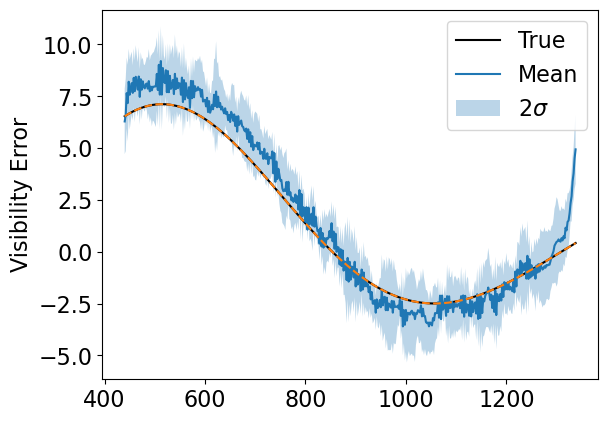

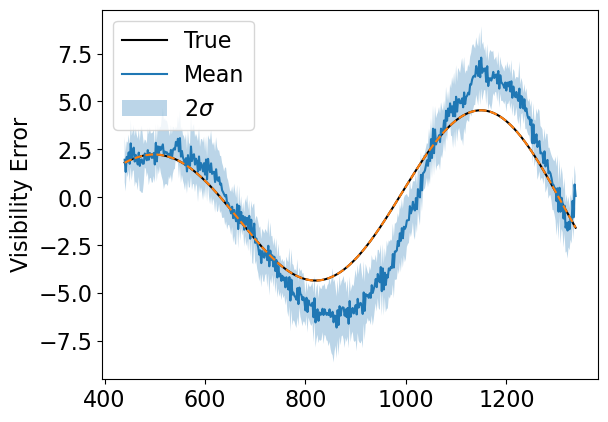

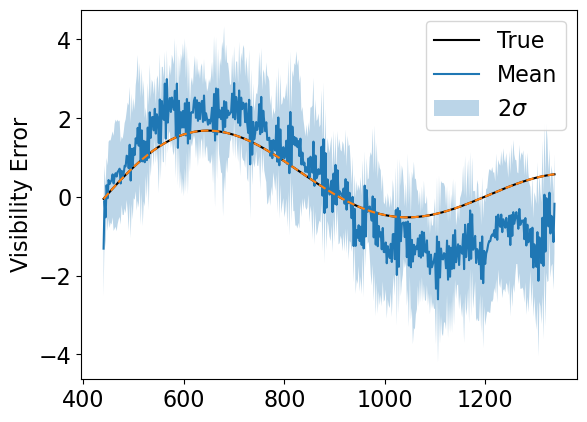

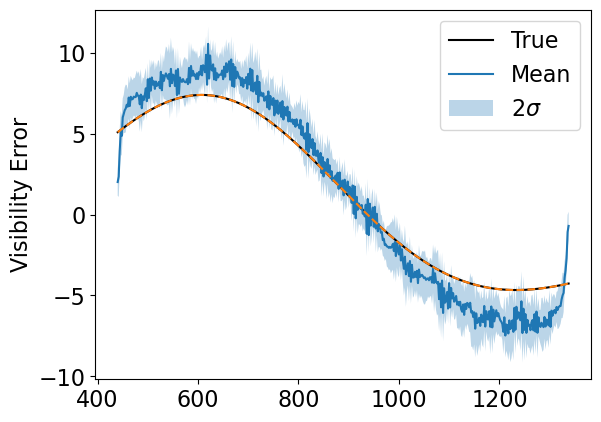

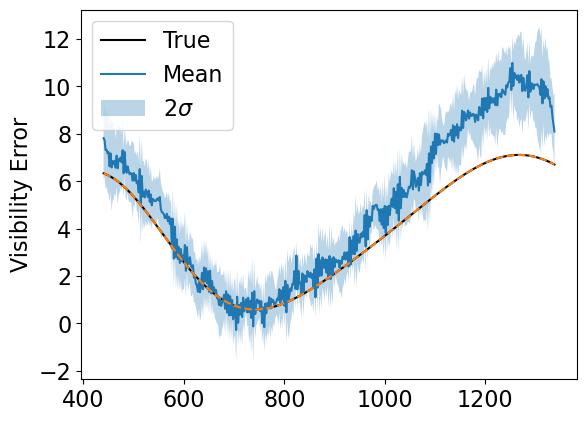

In [80]:
n_sigma = 2
for b in range(jnp.min(jnp.array([N_bl, 5]))):
    plt.figure()
    plt.plot(times, vis_ast_true[:,b].real, 'k', label="True")
    plt.plot(times, mean_vis[b].real, label="Mean")
    plt.fill_between(times, mean_vis[b].real - n_sigma*std_vis_r[b], 
                     mean_vis[b].real + n_sigma*std_vis_r[b], alpha=0.3, label=r"2$\sigma$")
    plt.plot(times, vis_ast_[b].real, '--')#, label="True Recon.")
    # plt.ylim(-10, 10)
    plt.ylabel("Visibility Error")
    plt.legend()

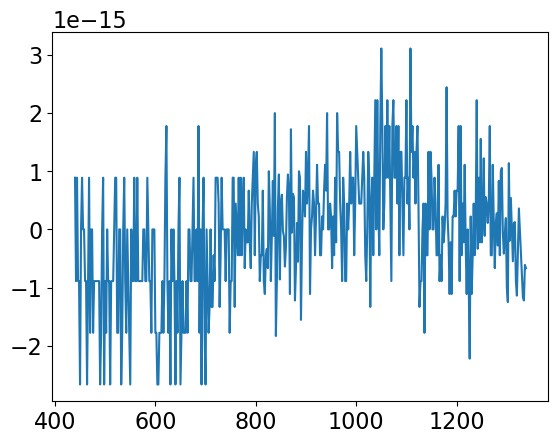

In [45]:
b = 0
# plt.plot(times, vis_ast_true[:,b].real-mean_vis[b].real)
plt.plot(times, vis_ast_true[:,b].real-vis_ast_[b].real)
# plt.fill_between(times, -2*std_vis_r[b], 2*std_vis_r[b], alpha=0.3)
# plt.ylim(-10, 10)

{'ast_k_i_base': Array([[ 8.62817704e+02, -1.52960341e+03, -9.56713002e+01, ...,
          6.09491605e+02,  1.21990464e+03,  5.20298596e+03],
        [ 3.08374494e+02, -8.10331958e+02,  1.62567277e+03, ...,
          4.72782796e+02,  2.66252187e+03, -4.47283801e+03],
        [-2.35990023e+02, -4.79466321e+02, -1.40382498e+02, ...,
         -1.15836922e+02, -2.58834121e+02,  9.53834322e+02],
        [-1.36835162e+04, -9.33948131e+03, -1.37881690e+03, ...,
         -6.15451824e+04, -3.26611805e+04, -1.94720098e+04],
        [-2.34710993e+04, -1.92065270e+04, -6.89555447e+03, ...,
         -1.80813696e+04, -6.26306604e+04,  2.72175475e+04],
        [ 3.43351221e+05,  2.08816869e+05, -6.86083512e+03, ...,
          2.94886316e+03,  6.27038118e+04,  1.82584578e+05]],      dtype=float64),
 'ast_k_r_base': Array([[ 5.15462553e+01,  3.30694459e+03,  5.61328715e+02, ...,
         -2.37400858e+02, -5.86605245e+02,  2.20537501e+02],
        [-9.69569183e+01, -4.41482008e+02,  3.02624353e+02, ...,